In [1]:
import itertools
import time
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from scipy import stats

#--- Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

#--- Import Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor,  plot_importance
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

#--- Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

import warnings
warnings.simplefilter(action="ignore")

In [2]:
data=pd.read_csv("../data/2013-2020_NORTH REGION.csv")

In [3]:
data=data.drop(columns='Unnamed: 0', axis=1)

In [4]:
def get_year_week(row):
    year = row['year']
    week = min(row['week'], 52)  # Set week to 52 if it is 53
    return datetime.date.fromisocalendar(year, week, 1)

data['year_week'] = data.apply(get_year_week, axis=1)

In [5]:
data.columns

Index(['year', 'week', 'cluster_sn', 'no_cases', 'latitude', 'longitude',
       'point', 'pln_area_n', 'region_n', 'pln_total_cases', 'reg_total_cases',
       'total_cases', 'total_daily_rainfall', 'highest_30min_rainfall',
       'highest_60min_rainfall', 'highest_120min_rainfall', 'max_wind_sp',
       'max_temp', 'rainy_day', 'mean_temp', 'mean_wind_sp', 'min_temp',
       'humidity', 'hdb_1_and_2_room_flats_hse', 'hdb_3_room_flats_hse',
       'hdb_4_room_flats_hse', 'hdb_5_room_and_executive_flats_hse',
       'condominiums_and_other_apartments_hse', 'landed_properties_hse',
       'others_hse', 'total_hdb_hse', 'hdb_1_and_2_room_flats_pop',
       'hdb_3_room_flats_pop', 'hdb_4_room_flats_pop',
       'hdb_5_room_and_executive_flats_pop',
       'condominiums_and_other_apartments_pop', 'landed_properties_pop',
       'others_pop', 'total_hdb_pop', 'total_pop', 'dengue_fever', 'dengue',
       'mosquito', 'insect_repellent', 'dengue_fever_diff',
       'dengue_fever_2nd_diff', '

In [6]:
# CHECK FOR STATIONARITY OF THE TIME SERIES
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [7]:
col_check= ['no_cases', 'pln_total_cases', 'reg_total_cases','total_cases', 
            'total_daily_rainfall', 'mean_temp', 'mean_wind_sp','humidity',
            'hdb_1_and_2_room_flats_pop','hdb_3_room_flats_pop', 'hdb_4_room_flats_pop',
            'hdb_5_room_and_executive_flats_pop','condominiums_and_other_apartments_pop', 
            'landed_properties_pop', 'others_pop', 'total_hdb_pop', 'total_pop',
            'dengue_fever','dengue','mosquito', 'insect_repellent']
for col in col_check:
    filtered_df=data[['year_week',col]].dropna().drop_duplicates()
    adfuller_test(filtered_df[col], name=col)
    print('\n')

    Augmented Dickey-Fuller Test on "no_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2657
 No. Lags Chosen       = 15
 Critical value 1%     = -3.437
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0165. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pln_total_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.4117
 No. Lags Chosen       = 14
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0003. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "reg_total_cases" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

Because $p \approx 5.27\times 10^{-11} < 0.05 = \alpha$, we reject $H_0$ that our data are not stationary and accept $H_A$ that our data are stationary. This means we can fit an ARIMA model to this data without differencing.

In [8]:
df = data[['year_week','reg_total_cases']]
df=df.drop_duplicates().sort_index()
df.set_index('year_week', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,reg_total_cases
year_week,
2013-05-20,84.0
2013-05-27,85.0
2013-06-10,130.0
2013-06-17,145.0
2013-06-24,174.0


In [9]:
# Define the training set
df=df.sort_index()
test = df.loc['2019-01-01':'2019-12-31']

In [10]:
# Define a function to create the persistence model
def persistence_model(data):
    # Shift the time series by one time step to create the lagged series
    lagged_data = data.shift(1)
    # Create the persistence model by using the previous observation as the prediction
    predictions = pd.Series(lagged_data.values.flatten(), index=data.index, name='predictions')
    return predictions

In [11]:
# Call the persistence_model function to make predictions
base_preds = persistence_model(data=test)

MAE: 30.024
RMSE: 49.718


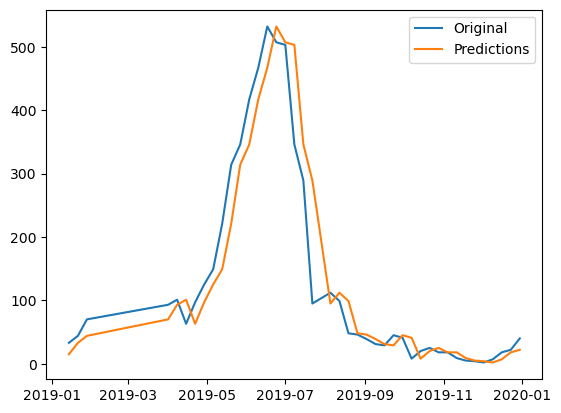

In [12]:
# Evaluate the performance of the model using a performance metric such as mean squared error
mae = mean_absolute_error(test[1:], base_preds[1:])
print('MAE: %.3f' % mae)
rmse= sqrt(mean_squared_error(test[1:], base_preds[1:]))
print('RMSE: %.3f' % rmse)
# Plot the original time series data and the predictions
plt.plot(test[1:])
plt.plot(base_preds[1:])
plt.legend(['Original', 'Predictions'])
plt.show()

In [13]:
pop=data[['year_week','pln_area_n','total_pop']].drop_duplicates()
pop=pop.groupby(['year_week']).agg({'total_pop':'sum'}).reset_index()

In [14]:
cases=data.groupby('year_week').size().reset_index(name='n_clusters')

In [15]:
df = data[['year_week','reg_total_cases','total_daily_rainfall','humidity','mean_temp','dengue_fever']]
df=df.drop_duplicates()

In [16]:
df=pd.merge(df,pop, on=['year_week'], how='left')
df=pd.merge(df,cases, on=['year_week'], how='left')
df=df.fillna(method="ffill")

In [17]:
df.set_index('year_week', inplace=True)
df.index = pd.to_datetime(df.index)
df.tail()

,reg_total_cases,total_daily_rainfall,humidity,mean_temp,dengue_fever,total_pop,n_clusters
year_week,,,,,,,
2020-06-01,89.0,5.704762,77.265708,27.014286,23.0,579380.0,13
2020-06-29,199.0,1.714286,74.881076,28.021429,24.0,579380.0,28
2020-08-03,406.0,0.276190,62.972850,28.757143,24.0,579380.0,36
2020-09-14,380.0,8.571429,71.990867,27.171429,12.0,580130.0,22
2020-11-02,132.0,5.550000,82.773202,26.940000,12.0,357770.0,10


In [18]:
df['cases_l1']=df['reg_total_cases'].shift(1)
df['cases_l2']=df['reg_total_cases'].shift(2)
df['cases_l3']=df['reg_total_cases'].shift(3)
df['cases_l4']=df['reg_total_cases'].shift(4)

df['clusters_l1']=df['n_clusters'].shift(1)
df['clusters_l2']=df['n_clusters'].shift(2)
df['clusters_l3']=df['n_clusters'].shift(3)
df['clusters_l4']=df['n_clusters'].shift(4)

df['rain_l1']=df['total_daily_rainfall'].shift(1)
df['rain_l2']=df['total_daily_rainfall'].shift(2)
df['rain_l3']=df['total_daily_rainfall'].shift(3)
df['rain_l4']=df['total_daily_rainfall'].shift(4)

df['humidity_l1']=df['humidity'].shift(1)
df['humidity_l2']=df['humidity'].shift(2)
df['humidity_l3']=df['humidity'].shift(3)
df['humidity_l4']=df['humidity'].shift(4)

df['temp_l1']=df['mean_temp'].shift(1)
df['temp_l2']=df['mean_temp'].shift(2)
df['temp_l3']=df['mean_temp'].shift(3)
df['temp_l4']=df['mean_temp'].shift(4)

df['fever_l1']=df['dengue_fever'].shift(1)
df['fever_l2']=df['dengue_fever'].shift(2)
df['fever_l3']=df['dengue_fever'].shift(3)
df['fever_l4']=df['dengue_fever'].shift(4)

df['pop_l1']=df['total_pop'].shift(1)
df['pop_l2']=df['total_pop'].shift(2)
df['pop_l3']=df['total_pop'].shift(3)
df['pop_l4']=df['total_pop'].shift(4)

In [19]:
# Define the training set
df=df.sort_index()
train = df.loc['2013-01-01':'2018-12-31'][4:]

# Define the testing set
test = df.loc['2019-01-01':'2019-12-31']

In [20]:
X_train = train.drop(columns='reg_total_cases')
y_train = train['reg_total_cases']

X_test = test.drop(columns='reg_total_cases')
y_test = test['reg_total_cases']

In [21]:
X_train.columns

Index(['total_daily_rainfall', 'humidity', 'mean_temp', 'dengue_fever',
       'total_pop', 'n_clusters', 'cases_l1', 'cases_l2', 'cases_l3',
       'cases_l4', 'clusters_l1', 'clusters_l2', 'clusters_l3', 'clusters_l4',
       'rain_l1', 'rain_l2', 'rain_l3', 'rain_l4', 'humidity_l1',
       'humidity_l2', 'humidity_l3', 'humidity_l4', 'temp_l1', 'temp_l2',
       'temp_l3', 'temp_l4', 'fever_l1', 'fever_l2', 'fever_l3', 'fever_l4',
       'pop_l1', 'pop_l2', 'pop_l3', 'pop_l4'],
      dtype='object')

In [22]:
# Create an XGBoost regressor object
xgb = XGBRegressor()

# Use SelectFromModel to select the most important features
selector = SelectFromModel(estimator=xgb, threshold='mean')
selector.fit(X_train, y_train)

# Get the selected feature names
mask = selector.get_support()
feature_names = X_train.columns[mask]

# Transform the original feature matrix using the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Fit the XGBoost regressor to the selected features
xgb_selected = XGBRegressor()
xgb_selected.fit(X_train_selected, y_train)

# Make predictions on the test data using the selected features
y_pred = xgb_selected.predict(X_test_selected)

# Compute the mean absolute error (MAE) of the model on the test data
mse = mean_absolute_error(y_test, y_pred)
print('Test MAE: {:.2f}'.format(mse))

Test MAE: 78.52


In [23]:
feature_names

Index(['n_clusters', 'cases_l1', 'fever_l2'], dtype='object')

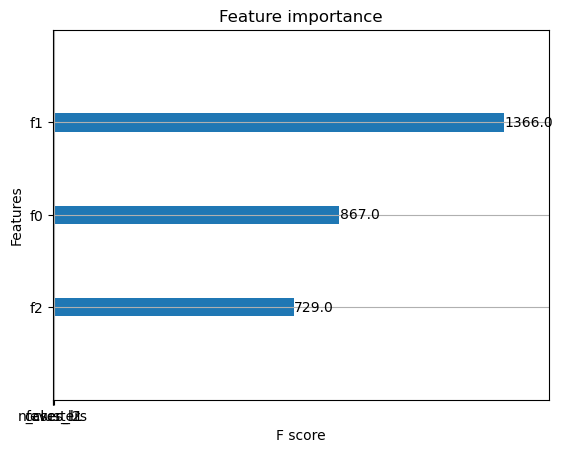

In [24]:
# Plot feature importance with the original feature names
plot_importance(xgb_selected)
plt.xticks(range(len(feature_names)), feature_names)
plt.show()

In [47]:
features=['n_clusters','cases_l1', 'fever_l2', 'total_daily_rainfall', 'humidity', 
          'mean_temp', 'dengue_fever','total_pop']

X_train = train[features]
y_train = train['reg_total_cases']

X_test=test[features]
y_test=test['reg_total_cases']

# Define the hyperparameter grid for the XGBoost regressor
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2,],
    'n_estimators': [5,7,10],
    'max_depth': [7, 9, 11],
    'subsample': [0.1, 0.3, 0.5],
    'colsample_bytree': [0.5, 0.8, 1]
}

# Create an XGBoost regressor object
xgb = XGBRegressor()

# Create a grid search object with 10-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean absolute error (MAE)
print("Best parameters: ", grid_search.best_params_)
print("Best MAE: ", -1 * grid_search.best_score_)

# Get the best model with the best hyperparameters
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model from the grid search
y_pred = best_model.predict(X_test)

# Compute the mean absolute error (MAE) of the best model on the test data
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: {:.2f}'.format(mae))
rmse= sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Best parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 10, 'subsample': 0.3}
Best MAE:  18.548027842923215
Test MAE: 76.25
Test RMSE: 141.241


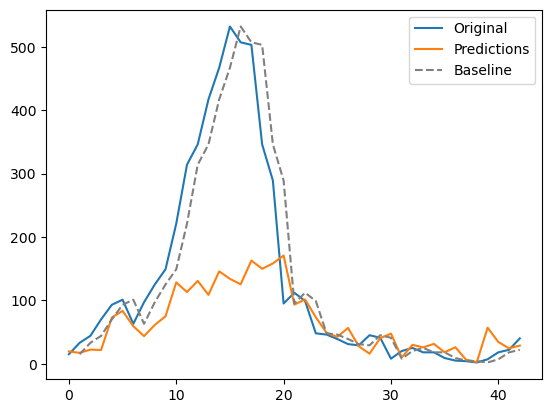

In [26]:
# Plot the original time series data and the predictions
plt.plot(y_test.values)
plt.plot(y_pred)
plt.plot(base_preds.values,linestyle='dashed',color='grey')
plt.legend(['Original', 'Predictions', 'Baseline'])
plt.show()

In [27]:
def residual_plot(res):
    '''
    Objective: Generates four charts to assess the residuals of the model predictions -  
    a residual line chart through time; an ACF plot of residuals; a residual Q-Q plot; 
    and a kde histogram of residuals
    
    res: Residuals between the true target variable values and the model predictions
    '''
    # Standardizing residual values
    resid_standard = (res - res.mean()) / res.std()
    
    # Generate 2X2 chart plots
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()
    

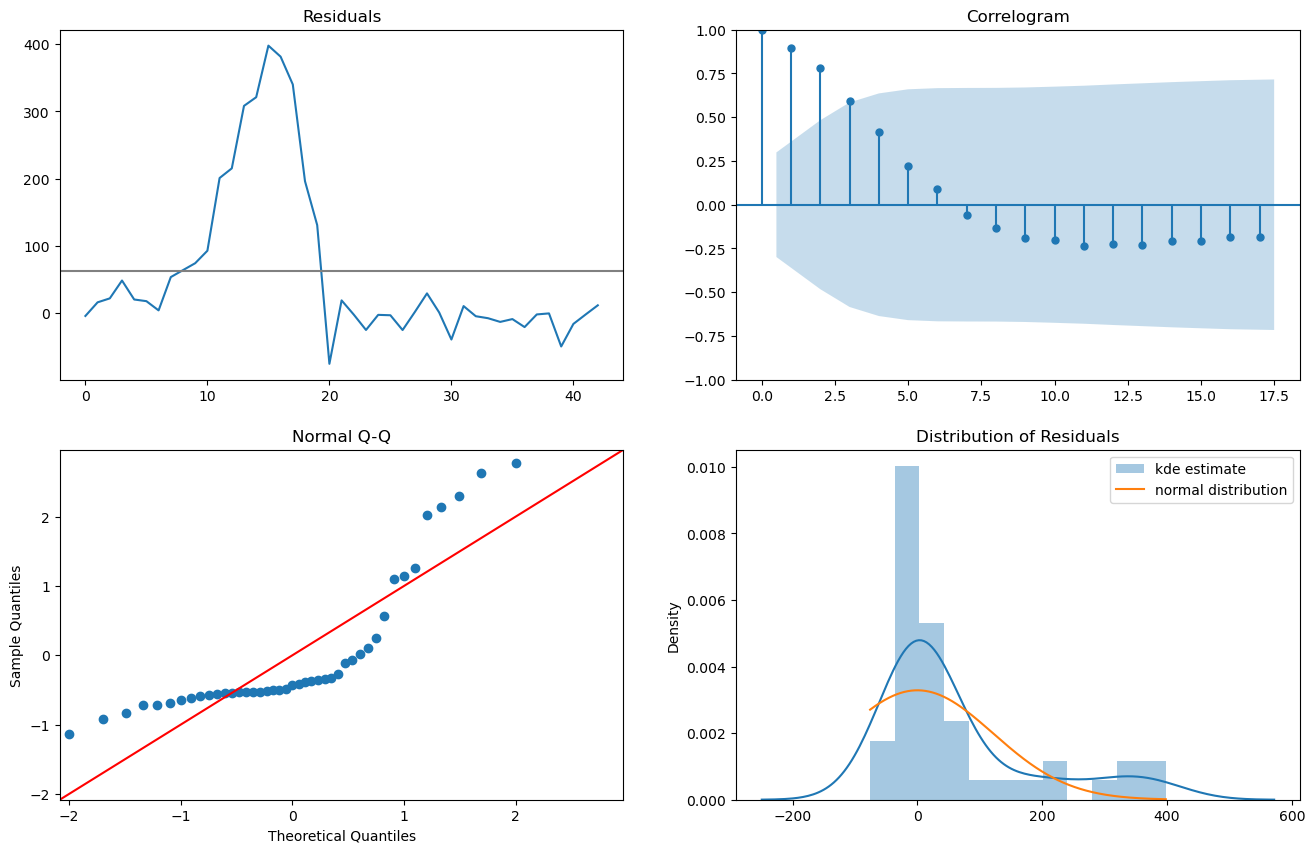

In [28]:
residuals=y_test.values-y_pred
residual_plot(residuals)

## Auto Arima

In [29]:
prophettrain=pd.DataFrame(y_train)
prophettrain=prophettrain.rename(columns={'reg_total_cases' : 'y'}).rename_axis("ds")

In [36]:
import pmdarima as pm
model = pm.auto_arima(prophettrain,start_p=0,start_q=0,test="adf",max_p=3,max_q=3,error_action="ignore",suppress_warnings=True,seasonal=False)
# prediction
pred = model.predict(43)

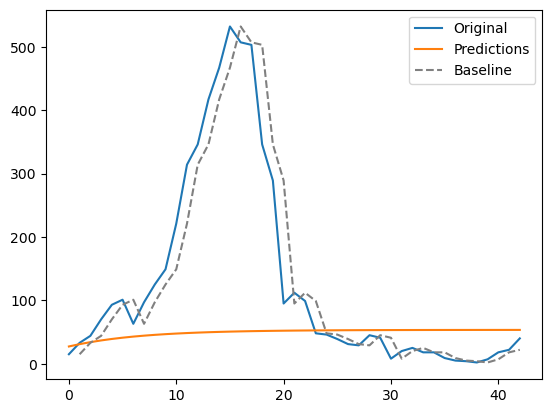

In [37]:
# Plot the original time series data and the predictions
plt.plot(y_test.values)
plt.plot(pred.values)
plt.plot(base_preds.values,linestyle='dashed',color='grey')
plt.legend(['Original', 'Predictions', 'Baseline'])
plt.show()

In [38]:
mae = mean_absolute_error(y_test, pred)
print('Test MAE: {:.2f}'.format(mae))
rmse= sqrt(mean_squared_error(y_test, pred))
print('Test RMSE: %.3f' % rmse)

Test MAE: 107.04
Test RMSE: 176.586


## OLS

In [39]:
def fit_linear_reg(X,Y):
    #Fit linear regression model 
    X2 = sm.add_constant(X)
    model_k = sm.OLS(Y,X2)
    fit = model_k.fit()
    pvalues = fit.pvalues
    worst_pval = pvalues.max() 
    worst_feature = pvalues.idxmax()
    Y_Pred_Test = fit.predict(sm.add_constant(test[list(X)]))
    
    # If the highest p-value corresponds to the intercept term ('const'), the model is refitted without it
    if worst_feature == 'const':
        model_k = sm.OLS(Y,X)
        fit = model_k.fit()
        pvalues = fit.pvalues
        worst_pval = pvalues.max() 
        worst_feature = pvalues.idxmax()
        Y_Pred_Test = fit.predict(test[list(X)])
    
    # get metrics to evaluate the performance of the model
    pval = fit.pvalues.to_frame()
    features = list(pval.index)
    pvals = list(pval[0])
    sig = pval[pval[0]<=0.05]
    pct_sig = len(list(sig[0])) / len(list(pval[0]))
    rsq = fit.rsquared
    adjr = fit.rsquared_adj
    serial_corr = list(sm.stats.diagnostic.acorr_breusch_godfrey(fit, nlags=3))[3]
    het_arch = list(sm.stats.diagnostic.het_arch(fit.resid, maxlag=1))[3]
    normality = list(sm.stats.stattools.jarque_bera(fit.resid))[1]
    
    mae = mean_absolute_error(Y_True_Test,Y_Pred_Test)
    mse = mean_squared_error(Y_True_Test,Y_Pred_Test)
    rmse = sqrt(mean_squared_error(Y_True_Test,Y_Pred_Test))
    return features, pvals, pct_sig, rsq, adjr, serial_corr, het_arch, normality, mae, mse, rmse, worst_pval, worst_feature

In [40]:
# INITIALIZE VARIABLES
X = train.drop(columns='reg_total_cases')
Y = train['reg_total_cases']
Y_True_Test = test['reg_total_cases']
threshold_out = 0.05

# initializes various lists to store the results of the backward stepwise regression
remaining_features = list(X.columns.values)
features = []
R_squared_list, AdjR2_list, feature_list, pval_list = [],[],[],[]
pct_sig_list = []
num_features = []
serial_corr_list = []
het_arch_list = []
norm_list = []
mae_list, mse_list, rmse_list = [],[],[]

# RUN BACKWARD STEPWISE REGRESSION 
#--- Remove predictors one at a time until there is no more p-value exceeding the threshold
while True:
    changed = False
    tmp_result = fit_linear_reg(X[list(set(remaining_features))],Y)  
    num_features.append(len(remaining_features)) 
    feature_list.append(tmp_result[0])
    pval_list.append(tmp_result[1])
    pct_sig_list.append(tmp_result[2])
    R_squared_list.append(tmp_result[3])
    AdjR2_list.append(tmp_result[4])
    serial_corr_list.append(tmp_result[5])
    het_arch_list.append(tmp_result[6])
    norm_list.append(tmp_result[7])
    mae_list.append(tmp_result[8])
    mse_list.append(tmp_result[9])
    rmse_list.append(tmp_result[10])
   
    if tmp_result[11] > threshold_out:
        changed = True
        if tmp_result[12] in remaining_features:
            remaining_features.remove(tmp_result[12])
        else:
            print(f"Warning: feature '{tmp_result[12]}' not found in remaining features")
        
    if not changed:
        break 

In [41]:
# STORE IN DATAFRAME
subsets_df = pd.DataFrame({'num_features': num_features, 'features': feature_list, 'P>|t|': pval_list, 'pct_sig': pct_sig_list, \
                          'rsq': R_squared_list, 'adj_rsq': AdjR2_list, 'serial_corr': serial_corr_list, 'het': het_arch_list, \
                          'normality': norm_list, 'mae': mae_list, 'mse': mse_list, 'rmse': rmse_list})

# GET ONLY THE TOP 3 MODELS BY ADJUSTED R-SQUARED
top3_subsets_df = subsets_df.nlargest(3,'adj_rsq').reset_index().drop(columns=['index'])
top3_subsets_df.index += 1

In [42]:
top3_subsets_df

,num_features,features,P>|t|,pct_sig,rsq,adj_rsq,serial_corr,het,normality,mae,mse,rmse
1,16,"[const, cases_l4, humidity, temp_l1, temp_l2, ...","[0.07232199938410726, 0.00036296706853303267, ...",0.470588,0.861324,0.848273,0.301921,0.330791,4.083724e-10,43.296240,4283.927621,65.451720
2,18,"[const, cases_l4, humidity, temp_l1, rain_l2, ...","[0.13599027617206114, 0.00026769400901603273, ...",0.368421,0.862874,0.848181,0.424048,0.281039,3.950702e-08,43.862965,4345.281744,65.918751
3,17,"[const, cases_l4, humidity, temp_l1, rain_l2, ...","[0.1348236379066045, 0.00027975299830751936, 0...",0.388889,0.862022,0.848143,0.332114,0.272132,1.439908e-07,43.901241,4372.703749,66.126422


In [43]:
# RERUN THE TOP 3 MODELS AND STORE THE FORECASTS FOR BOTH TRAINING AND TEST SETS
Y = train['reg_total_cases']

for i in range(1,4):
    top = top3_subsets_df['features'][i]
    if top.count('const') == 0:
        X = train[top]    
        reg = LinearRegression(fit_intercept=False)

    if top.count('const') > 0:
        top.remove('const')
        X = train[top]    
        reg = LinearRegression(fit_intercept=True)

    reg.fit(X,Y)
    prediction = pd.DataFrame(reg.predict(X))
    prediction.columns = ['Pred_Model_'] 
    prediction.columns += str(i)
    if i == 1:
        train2 = train.reset_index().join(prediction, how='inner')
    if i > 1:
        train2 = train2.reset_index().join(prediction, how='inner')

    prediction = pd.DataFrame(reg.predict(test[X.columns]))
    prediction.columns = ['Pred_Model_']
    prediction.columns += str(i)
    if i == 1:
        test2 = test.reset_index().join(prediction, how='inner')
    if i > 1:
        test2 = test2.reset_index().join(prediction, how='inner')

In [44]:
test2.set_index('year_week', inplace=True)

Test MAE: 43.90
Test RMSE: 66.126


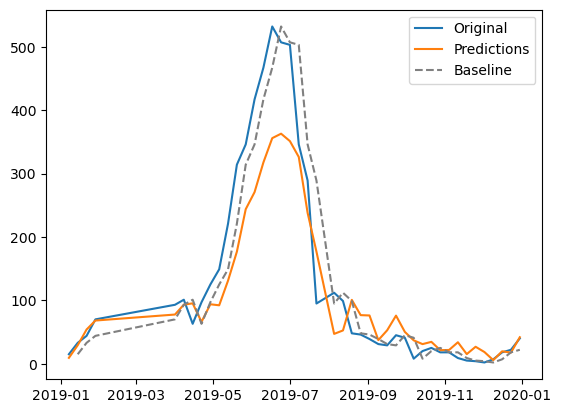

In [45]:
# Evaluate the performance of the model using a performance metric such as mean squared error
mae = mean_absolute_error(test2['reg_total_cases'], test2['Pred_Model_3'])
print('Test MAE: {:.2f}'.format(mae))
rmse= sqrt(mean_squared_error(test2['reg_total_cases'], test2['Pred_Model_3']))
print('Test RMSE: %.3f' % rmse)

# Plot the original time series data and the predictions
plt.plot(test2['reg_total_cases'])
plt.plot(test2['Pred_Model_3'])
plt.plot(base_preds[1:],linestyle='dashed',color='grey')
plt.legend(['Original', 'Predictions', 'Baseline'])
plt.show()

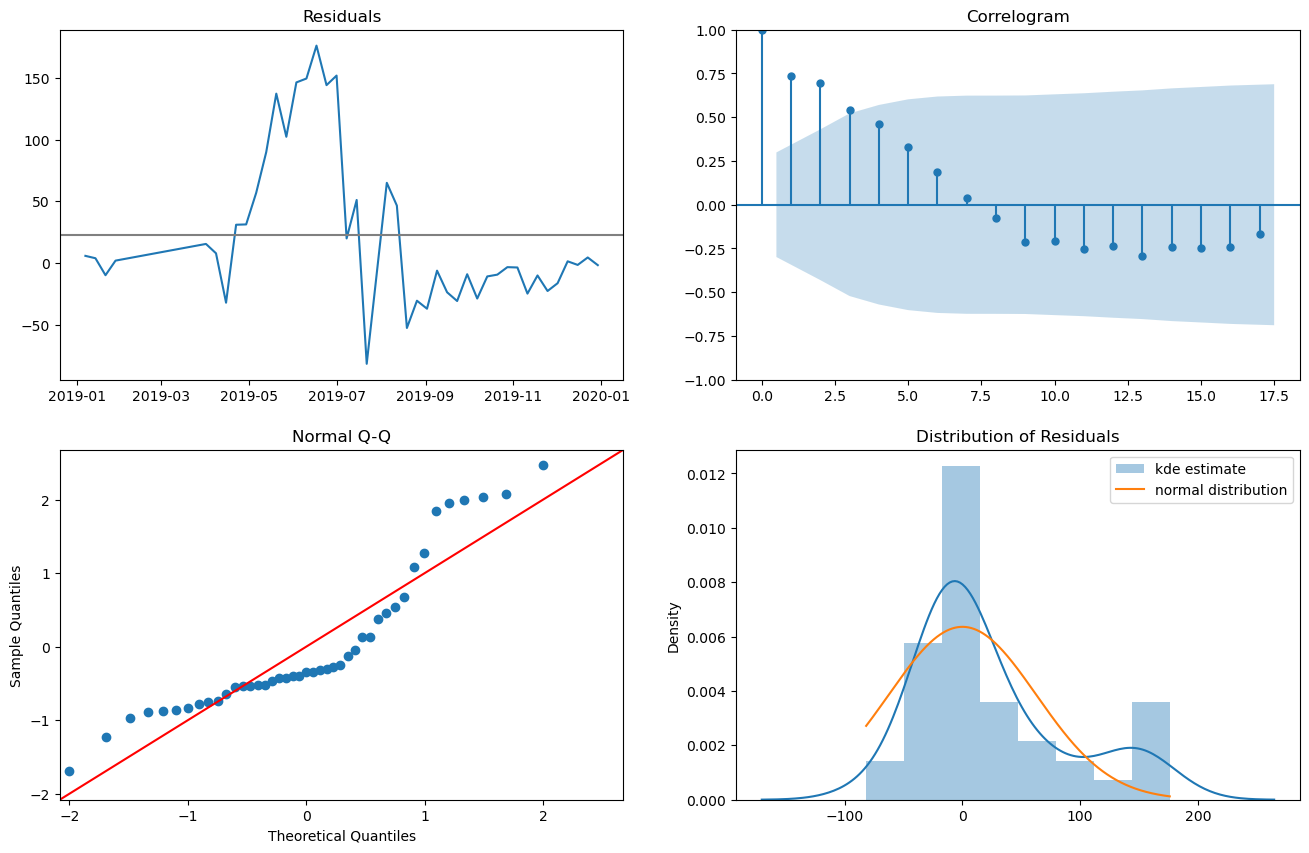

In [46]:
residuals=test2['reg_total_cases']- test2['Pred_Model_3']
residual_plot(residuals)